# Analyze Negotiation Results

This notebook loads a negotiation log CSV, ignores the `conversation_history` column, parses item valuations and final allocations, and computes per‑round metrics for later plotting:
- Agent 1 Utility
- Agent 2 Utility
- Current Welfare
- Max Welfare
- Welfare Efficiency (current/max)

Run the cells below and use the last cell to quickly verify values for the first round.

In [1]:
from __future__ import annotations
import pandas as pd
import json
from pathlib import Path
from typing import Dict, Any, List, Tuple
import math
from IPython.display import display
import numpy as np

pd.options.display.width = 120
pd.options.display.max_colwidth = 200


In [2]:
LOG_PATH = "logs/gpt-oss_20b_default_vs_rude_4_20250930_2337.csv"

In [3]:
def parse_items_data(items_str: str) -> Dict[str, Dict[str, float]]:
    """Parse the items_data JSON into a mapping {item_name: {'agent1': float, 'agent2': float}}."""
    if items_str is None or (isinstance(items_str, float) and math.isnan(items_str)) or items_str == "":
        return {}
    data = json.loads(items_str)
    items: Dict[str, Dict[str, float]] = {}
    for item in data:
        name = item.get("name")
        if not name:
            # Skip malformed entries
            continue
        a1_val = float(item.get("agent1_value", 0.0))
        a2_val = float(item.get("agent2_value", 0.0))
        items[name] = {"agent1": a1_val, "agent2": a2_val}
    return items

def parse_final_allocation(alloc_str: str) -> Dict[str, List[str]]:
    """Parse the final_allocation JSON into {agent1: [...], agent2: [...]}. Accepts either keys 'agent1'/'agent2' or 'agent1_items'/'agent2_items'."""
    if alloc_str is None or (isinstance(alloc_str, float) and math.isnan(alloc_str)) or alloc_str == "":
        return {"agent1": [], "agent2": []}
    data = json.loads(alloc_str)
    a1_list = data.get("agent1", data.get("agent1_items", [])) or []
    a2_list = data.get("agent2", data.get("agent2_items", [])) or []
    # Ensure lists
    a1_list = list(a1_list)
    a2_list = list(a2_list)
    return {"agent1": a1_list, "agent2": a2_list}

def compute_round_metrics(items_map: Dict[str, Dict[str, float]], final_alloc: Dict[str, List[str]]) -> Dict[str, float]:
    """Compute normalized utilities and welfare metrics for a round."""
    # Compute raw utilities
    a1_util = sum(items_map[i]["agent1"] for i in final_alloc.get("agent1", []) if i in items_map)
    a2_util = sum(items_map[i]["agent2"] for i in final_alloc.get("agent2", []) if i in items_map)
    # Compute max possible utility for each agent in this round
    a1_max = sum(v["agent1"] for v in items_map.values()) if items_map else 1.0
    a2_max = sum(v["agent2"] for v in items_map.values()) if items_map else 1.0
    # Normalize utilities to [0, 1] for this round
    a1_util_norm = a1_util / a1_max if a1_max else 0.0
    a2_util_norm = a2_util / a2_max if a2_max else 0.0
    current_welfare = a1_util + a2_util
    max_welfare = sum(max(v["agent1"], v["agent2"]) for v in items_map.values())
    welfare_eff = (current_welfare / max_welfare) if max_welfare and max_welfare > 0 else math.nan
    return {
        "agent1_utility": a1_util_norm,
        "agent2_utility": a2_util_norm,
        "current_welfare": current_welfare,
        "max_welfare": max_welfare,
        "welfare_efficiency": welfare_eff,
        "agent1_utility_raw": a1_util,
        "agent2_utility_raw": a2_util,
        "agent1_utility_max": a1_max,
        "agent2_utility_max": a2_max,
    }

def _compute_metrics_row(row: pd.Series) -> pd.Series:
    items_map = parse_items_data(row.get("items_data"))
    final_alloc = parse_final_allocation(row.get("final_allocation"))
    metrics = compute_round_metrics(items_map, final_alloc)
    return pd.Series(metrics)

def load_log_file(csv_path: Path | str) -> pd.DataFrame:
    """Load a single CSV log file, ignoring 'conversation_history', and compute round metrics. Returns a DataFrame with original columns (minus conversation_history) plus the metrics columns."""
    import csv
    # Increase CSV field size limit
    csv.field_size_limit(10 * 1024 * 1024)  # Set to 10MB
    
    path = Path(csv_path)
    if not path.exists():
        raise FileNotFoundError(f"CSV not found: {path}")
    # Read while ignoring the large conversation_history column
    df = pd.read_csv(
        path,
        engine="python",
        encoding="utf-8",
        usecols=lambda c: c != "conversation_history",
    )
    # Compute metrics per row
    metrics_df = df.apply(_compute_metrics_row, axis=1)
    out = pd.concat([df, metrics_df], axis=1)
    # Helpful type coercions for later plotting
    for col in ["round_number", "num_items", "turn_count", "starting_agent"]:
        if col in out.columns:
            out[col] = pd.to_numeric(out[col], errors="coerce")
    return out

In [4]:
# Set your CSV path here. Defaults to one from the 'logs' folder if present.
default_csv = Path(LOG_PATH)
csv_path = default_csv if default_csv.exists() else None
if csv_path is None:
    print("Default CSV not found. Set 'csv_path' to your log file path, then run the next cell.")
else:
    print(f"Using CSV: {csv_path}")


Using CSV: logs\gpt-oss_20b_default_vs_rude_4_20250930_2337.csv


In [5]:
# Increase the CSV field size limit before loading
import csv
import sys

# Set to maximum possible size
max_int = sys.maxsize

# If that fails, try lower values until it works
while True:
    try:
        csv.field_size_limit(max_int)
        break
    except OverflowError:
        max_int = int(max_int/10)

print(f"Set CSV field size limit to: {max_int:,} bytes")

Set CSV field size limit to: 9,223,372,036,854,775,807 bytes


In [6]:
if csv_path is not None:
    try:
        # Read the file with increased field size limit
        metrics_df = load_log_file(csv_path)
        print(f"Loaded {len(metrics_df)} rounds from {csv_path.name}")
        
        # Display the first few rows (excluding very long columns)
        cols_to_show = [
            c for c in metrics_df.columns
            if c not in {"items_data", "final_allocation", "proposal_history"}
        ] + ["agent1_utility", "agent2_utility", "current_welfare", "max_welfare", "welfare_efficiency"]
        display(metrics_df[cols_to_show].head(3))
    except Exception as e:
        print(f"Error loading CSV: {type(e).__name__}: {e}")

Loaded 100 rounds from gpt-oss_20b_default_vs_rude_4_20250930_2337.csv


,session_id,model_name,num_items,timestamp,date,agent1_type,agent2_type,boulware_initial_threshold,boulware_decrease_rate,boulware_min_threshold,...,welfare_efficiency,agent1_utility_raw,agent2_utility_raw,agent1_utility_max,agent2_utility_max,agent1_utility,agent2_utility,current_welfare,max_welfare,welfare_efficiency
0,gpt-oss_20b_default_vs_rude_4_20250930_233718,gpt-oss_20b_default_vs_rude,4,2025-09-30T23:38:22.345285,2025-09-30,default,rude,NaN,NaN,NaN,...,0.843750,1.0,1.7,1.3,3.2,0.769231,0.531250,2.7,3.2,0.843750
1,gpt-oss_20b_default_vs_rude_4_20250930_233718,gpt-oss_20b_default_vs_rude,4,2025-09-30T23:47:18.880584,2025-09-30,default,rude,NaN,NaN,NaN,...,0.894737,0.5,1.2,1.0,1.8,0.500000,0.666667,1.7,1.9,0.894737
2,gpt-oss_20b_default_vs_rude_4_20250930_233718,gpt-oss_20b_default_vs_rude,4,2025-09-30T23:48:19.425411,2025-09-30,default,rude,NaN,NaN,NaN,...,1.000000,0.7,1.9,2.2,2.6,0.318182,0.730769,2.6,2.6,1.000000


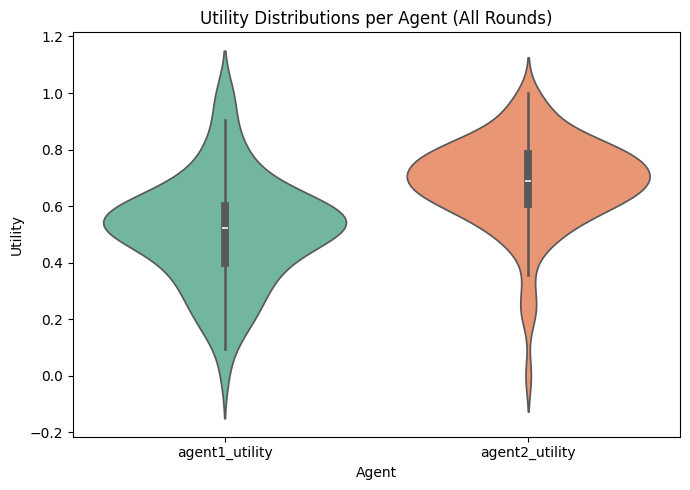

### Agent Utility Comparison Analysis

,Statistic,Agent1,Agent2
0,Mean,0.513,0.681
1,Median,0.524,0.688
2,Std Dev,0.188,0.159
3,Min,0.000,0.000
4,Max,1.000,1.000
5,Count,100,100


#### Statistical Significance Test

**Independent t-test**:

- t-statistic: -6.816

- p-value: 0.0000 (statistically significant)

- Effect size (Cohen's d): 0.964 (large)

#### Summary

Agent 1 (default) achieved a mean utility of 0.513, while Agent 2 (rude) achieved 0.681. 

The difference between agents is statistically significant (p=0.0000), with Agent 2 performing better overall. The effect size is large (d=0.964).

In [7]:
# Utility Distributions per Agent (Violin Plot)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from IPython.display import Markdown, display

if 'metrics_df' in globals() and not metrics_df.empty:
    # Prepare data for plotting
    plot_df = metrics_df[['agent1_utility', 'agent2_utility']].copy()
    plot_df = plot_df.melt(var_name='Agent', value_name='Utility')

    plt.figure(figsize=(7, 5))
    sns.violinplot(x='Agent', y='Utility', hue='Agent', data=plot_df, inner='box', palette='Set2', legend=False)
    plt.title('Utility Distributions per Agent (All Rounds)')
    plt.xlabel('Agent')
    plt.ylabel('Utility')
    plt.tight_layout()
    plt.show()
    
    # Statistical Analysis
    display(Markdown("### Agent Utility Comparison Analysis"))
    
    # Extract utilities for both agents
    agent1_utils = metrics_df['agent1_utility'].dropna()
    agent2_utils = metrics_df['agent2_utility'].dropna()
    
    # Descriptive statistics
    agent1_mean = agent1_utils.mean()
    agent2_mean = agent2_utils.mean()
    agent1_median = agent1_utils.median()
    agent2_median = agent2_utils.median()
    agent1_std = agent1_utils.std()
    agent2_std = agent2_utils.std()
    
    # Display statistics
    stats_df = pd.DataFrame({
        'Statistic': ['Mean', 'Median', 'Std Dev', 'Min', 'Max', 'Count'],
        'Agent1': [
            f"{agent1_mean:.3f}",
            f"{agent1_median:.3f}",
            f"{agent1_std:.3f}",
            f"{agent1_utils.min():.3f}",
            f"{agent1_utils.max():.3f}",
            f"{len(agent1_utils)}"
        ],
        'Agent2': [
            f"{agent2_mean:.3f}",
            f"{agent2_median:.3f}",
            f"{agent2_std:.3f}",
            f"{agent2_utils.min():.3f}",
            f"{agent2_utils.max():.3f}",
            f"{len(agent2_utils)}"
        ]
    })
    
    display(stats_df)
    
    # T-test to compare means
    t_stat, p_val = stats.ttest_ind(agent1_utils, agent2_utils, equal_var=False)
    
    display(Markdown("#### Statistical Significance Test"))
    display(Markdown(f"**Independent t-test**:"))
    display(Markdown(f"- t-statistic: {t_stat:.3f}"))
    display(Markdown(f"- p-value: {p_val:.4f} ({'statistically significant' if p_val < 0.05 else 'not statistically significant'})"))
    
    # Calculate effect size (Cohen's d)
    pooled_std = np.sqrt((agent1_std**2 + agent2_std**2) / 2)
    effect_size = abs(agent1_mean - agent2_mean) / pooled_std
    
    if effect_size < 0.2:
        effect_desc = "negligible"
    elif effect_size < 0.5:
        effect_desc = "small"
    elif effect_size < 0.8:
        effect_desc = "medium"
    else:
        effect_desc = "large"
    
    display(Markdown(f"- Effect size (Cohen's d): {effect_size:.3f} ({effect_desc})"))
    
    # Summary
    display(Markdown("#### Summary"))
    
    # Get agent types if available
    if 'agent1_type' in metrics_df.columns and 'agent2_type' in metrics_df.columns:
        agent1_type = metrics_df['agent1_type'].iloc[0]
        agent2_type = metrics_df['agent2_type'].iloc[0]
        display(Markdown(f"Agent 1 ({agent1_type}) achieved a mean utility of {agent1_mean:.3f}, " +
                         f"while Agent 2 ({agent2_type}) achieved {agent2_mean:.3f}. "))
    else:
        display(Markdown(f"Agent 1 achieved a mean utility of {agent1_mean:.3f}, " +
                         f"while Agent 2 achieved {agent2_mean:.3f}. "))
    
    if p_val < 0.05:
        better_agent = "Agent 1" if agent1_mean > agent2_mean else "Agent 2"
        display(Markdown(f"The difference between agents is statistically significant (p={p_val:.4f}), " +
                         f"with {better_agent} performing better overall. " +
                         f"The effect size is {effect_desc} (d={effect_size:.3f})."))
    else:
        display(Markdown(f"There is no statistically significant difference between the agents' performance " +
                         f"(p={p_val:.4f}), suggesting that both agents achieved comparable results overall."))
else:
    print("metrics_df not available yet. Run the loading cells above.")

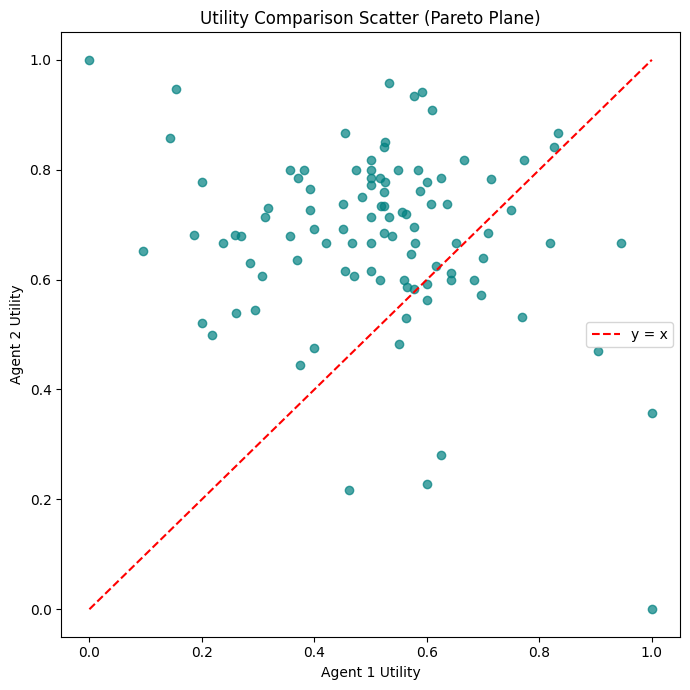

### Pareto Efficiency Analysis

#### Correlation Analysis

- Pearson correlation: -0.2225

- p-value: 0.0261 (statistically significant)

- Strength: weak negative correlation

- This suggests a primarily competitive negotiation dynamic

#### Distribution Relative to Equal Utility Line

- Negotiations favoring Agent 1: 20 (20.0%)

- Negotiations favoring Agent 2: 80 (80.0%)

- Equal utility outcomes: 0 (0.0%)

#### Pareto Efficiency

- Pareto-efficient outcomes: 7 out of 100 (7.0%)

### Summary

The negotiations show a weak negative correlation (r=-0.222, p=0.0261) between agent utilities, with mixed competitive and cooperative elements. 7.0% of negotiations reached Pareto-efficient outcomes.

In [8]:
# Utility Comparison Scatter (Pareto Plane)
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from IPython.display import Markdown, display

if 'metrics_df' in globals() and not metrics_df.empty:
    plt.figure(figsize=(7, 7))
    plt.scatter(metrics_df['agent1_utility'], metrics_df['agent2_utility'], alpha=0.7, color='teal')
    # Add y=x reference line
    min_util = min(metrics_df['agent1_utility'].min(), metrics_df['agent2_utility'].min())
    max_util = max(metrics_df['agent1_utility'].max(), metrics_df['agent2_utility'].max())
    plt.plot([min_util, max_util], [min_util, max_util], 'r--', label='y = x')
    plt.xlabel('Agent 1 Utility')
    plt.ylabel('Agent 2 Utility')
    plt.title('Utility Comparison Scatter (Pareto Plane)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Statistical Analysis
    display(Markdown("### Pareto Efficiency Analysis"))
    
    # Calculate correlation between agent utilities
    correlation, p_val = stats.pearsonr(metrics_df['agent1_utility'], metrics_df['agent2_utility'])
    
    # Categorize correlation strength
    if abs(correlation) < 0.3:
        corr_desc = "weak"
    elif abs(correlation) < 0.6:
        corr_desc = "moderate"
    else:
        corr_desc = "strong"
        
    # Determine relationship direction
    relationship = "negative" if correlation < 0 else "positive"
    game_desc = "cooperative" if correlation > 0 else "competitive"
    
    display(Markdown("#### Correlation Analysis"))
    display(Markdown(f"- Pearson correlation: {correlation:.4f}"))
    display(Markdown(f"- p-value: {p_val:.4f} ({'statistically significant' if p_val < 0.05 else 'not statistically significant'})"))
    display(Markdown(f"- Strength: {corr_desc} {relationship} correlation"))
    display(Markdown(f"- This suggests a primarily {game_desc} negotiation dynamic"))
    
    # Analyze distribution relative to the y=x line
    above_line = metrics_df[metrics_df['agent2_utility'] > metrics_df['agent1_utility']]
    below_line = metrics_df[metrics_df['agent2_utility'] < metrics_df['agent1_utility']]
    on_line = metrics_df[metrics_df['agent2_utility'] == metrics_df['agent1_utility']]
    
    total_rounds = len(metrics_df)
    
    display(Markdown("#### Distribution Relative to Equal Utility Line"))
    display(Markdown(f"- Negotiations favoring Agent 1: {len(below_line)} ({len(below_line)/total_rounds*100:.1f}%)"))
    display(Markdown(f"- Negotiations favoring Agent 2: {len(above_line)} ({len(above_line)/total_rounds*100:.1f}%)"))
    display(Markdown(f"- Equal utility outcomes: {len(on_line)} ({len(on_line)/total_rounds*100:.1f}%)"))
    
    # Pareto efficiency check (approximation)
    # A solution is Pareto efficient if no other solution can make one agent better off
    # without making the other agent worse off
    is_pareto = np.ones(len(metrics_df), dtype=bool)
    
    for i in range(len(metrics_df)):
        u1 = metrics_df['agent1_utility'].iloc[i]
        u2 = metrics_df['agent2_utility'].iloc[i]
        
        # Check if any other point dominates this one
        for j in range(len(metrics_df)):
            if i != j:
                v1 = metrics_df['agent1_utility'].iloc[j]
                v2 = metrics_df['agent2_utility'].iloc[j]
                
                # If another point is strictly better in both dimensions
                if v1 >= u1 and v2 >= u2 and (v1 > u1 or v2 > u2):
                    is_pareto[i] = False
                    break
    
    pareto_points = metrics_df[is_pareto]
    
    display(Markdown("#### Pareto Efficiency"))
    display(Markdown(f"- Pareto-efficient outcomes: {len(pareto_points)} out of {total_rounds} ({len(pareto_points)/total_rounds*100:.1f}%)"))
    
    # Summary
    display(Markdown("### Summary"))
    if correlation < -0.5:
        summary_text = (
            f"The negotiations show a {corr_desc} competitive dynamic (r={correlation:.3f}, p={p_val:.4f}), " +
            f"with Agent 1 receiving higher utility in {len(below_line)} rounds and Agent 2 in {len(above_line)} rounds. " +
            f"Only {len(pareto_points)/total_rounds*100:.1f}% of negotiations reached Pareto-efficient outcomes, " +
            f"suggesting significant room for improvement in negotiation efficiency."
        )
    elif correlation > 0.5:
        summary_text = (
            f"The negotiations show a {corr_desc} cooperative dynamic (r={correlation:.3f}, p={p_val:.4f}), " +
            f"with both agents often achieving high utilities simultaneously. " +
            f"{len(pareto_points)/total_rounds*100:.1f}% of negotiations reached Pareto-efficient outcomes, " +
            f"indicating generally effective negotiations."
        )
    else:
        summary_text = (
            f"The negotiations show a {corr_desc} {relationship} correlation (r={correlation:.3f}, p={p_val:.4f}) " +
            f"between agent utilities, with mixed competitive and cooperative elements. " +
            f"{len(pareto_points)/total_rounds*100:.1f}% of negotiations reached Pareto-efficient outcomes."
        )
    
    display(Markdown(summary_text))
else:
    print("metrics_df not available yet. Run the loading cells above.")

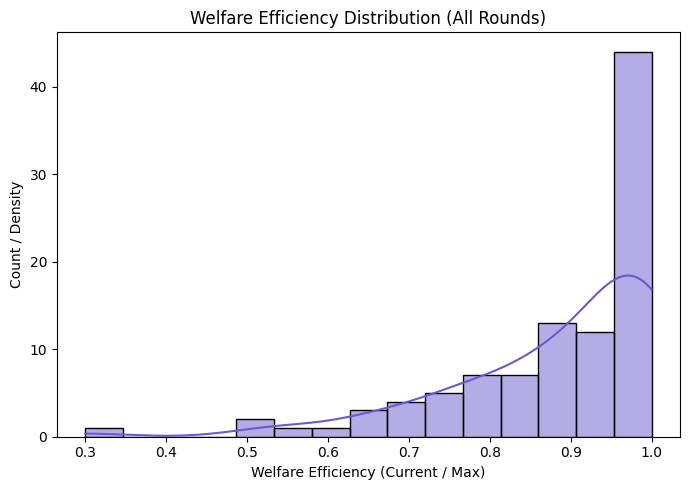

In [9]:
# Welfare Efficiency Distribution (Histogram/KDE)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

if 'metrics_df' in globals() and not metrics_df.empty:
    # Copy and prep data
    eff_vals = metrics_df['welfare_efficiency'].dropna()
    plt.figure(figsize=(7, 5))
    sns.histplot(eff_vals, kde=True, bins=15, color='slateblue', edgecolor='black')
    plt.title('Welfare Efficiency Distribution (All Rounds)')
    plt.xlabel('Welfare Efficiency (Current / Max)')
    plt.ylabel('Count / Density')
    plt.tight_layout()
    plt.show()
else:
    print("metrics_df not available yet. Run the loading cells above.")

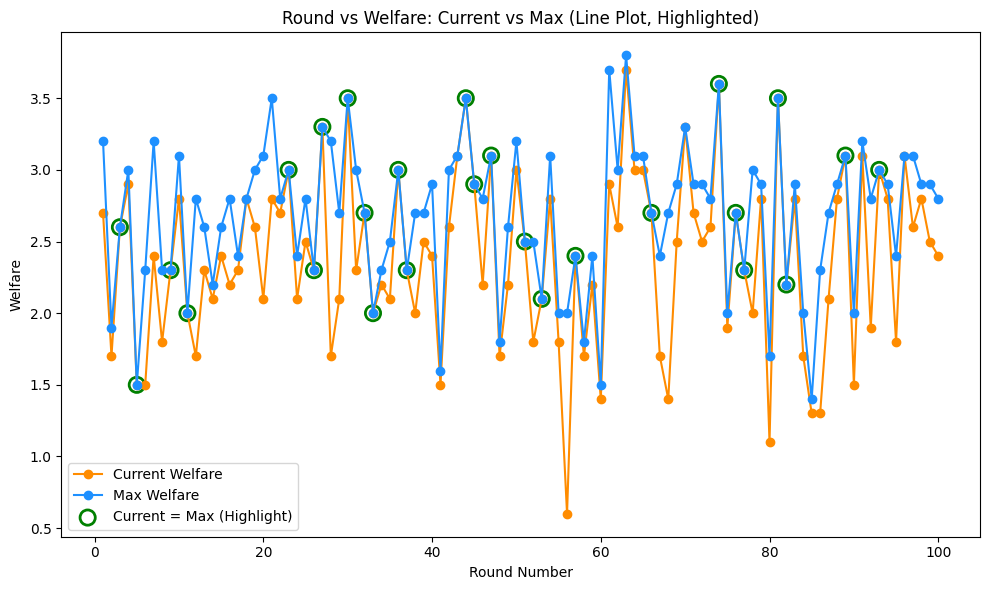

### Welfare Achievement Analysis

#### Welfare Statistics

- Mean current welfare: 2.386 ± 0.599

- Mean maximum welfare: 2.688 ± 0.510

- Average efficiency ratio (current/max): 0.886 (88.6%)

- Rounds with optimal welfare: 26 out of 100 (26.0%)

#### Statistical Significance Test

**Paired t-test** (comparing current vs. maximum welfare):

- t-statistic: -8.646

- p-value: 0.0000 (statistically significant)

- Effect size (Cohen's d): 0.869 (large)

#### Trend Analysis

- Welfare efficiency declining across rounds (slope=-0.0000)

- Statistical significance: not significant (p=0.9331)

### Summary

The negotiations achieved moderate welfare efficiency with an average of 88.6% of the maximum possible welfare. The difference between achieved and maximum welfare is statistically significant (p=0.0000) with a large effect size. No significant trend in welfare efficiency was observed across rounds.

In [10]:
# Line Plot: Round vs Welfare (Current & Max) with Highlighted Max Matches
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from IPython.display import Markdown, display

if 'metrics_df' in globals() and not metrics_df.empty:
    plot_df = metrics_df.copy()
    plt.figure(figsize=(10, 6))
    # Plot lines
    plt.plot(plot_df['round_number'], plot_df['current_welfare'], marker='o', color='darkorange', label='Current Welfare')
    plt.plot(plot_df['round_number'], plot_df['max_welfare'], marker='o', color='dodgerblue', label='Max Welfare')
    # Highlight points where current welfare == max welfare
    matches = plot_df[plot_df['current_welfare'] == plot_df['max_welfare']]
    plt.scatter(matches['round_number'], matches['current_welfare'], facecolors='none', edgecolors='green', s=120, linewidths=2, label='Current = Max (Highlight)')
    plt.xlabel('Round Number')
    plt.ylabel('Welfare')
    plt.title('Round vs Welfare: Current vs Max (Line Plot, Highlighted)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Statistical Analysis
    display(Markdown("### Welfare Achievement Analysis"))
    
    # Calculate basic statistics
    mean_current = plot_df['current_welfare'].mean()
    mean_max = plot_df['max_welfare'].mean()
    std_current = plot_df['current_welfare'].std()
    std_max = plot_df['max_welfare'].std()
    
    # Calculate ratio of current to max welfare
    plot_df['welfare_ratio'] = plot_df['current_welfare'] / plot_df['max_welfare']
    mean_ratio = plot_df['welfare_ratio'].mean()
    
    display(Markdown("#### Welfare Statistics"))
    display(Markdown(f"- Mean current welfare: {mean_current:.3f} ± {std_current:.3f}"))
    display(Markdown(f"- Mean maximum welfare: {mean_max:.3f} ± {std_max:.3f}"))
    display(Markdown(f"- Average efficiency ratio (current/max): {mean_ratio:.3f} ({mean_ratio*100:.1f}%)"))
    display(Markdown(f"- Rounds with optimal welfare: {len(matches)} out of {len(plot_df)} ({len(matches)/len(plot_df)*100:.1f}%)"))
    
    # Perform paired t-test between current and max welfare
    t_stat, p_val = stats.ttest_rel(plot_df['current_welfare'], plot_df['max_welfare'])
    
    display(Markdown("#### Statistical Significance Test"))
    display(Markdown(f"**Paired t-test** (comparing current vs. maximum welfare):"))
    display(Markdown(f"- t-statistic: {t_stat:.3f}"))
    display(Markdown(f"- p-value: {p_val:.4f} ({'statistically significant' if p_val < 0.05 else 'not statistically significant'})"))
    
    # Calculate effect size (Cohen's d for paired data)
    effect_size = abs(mean_current - mean_max) / np.std(plot_df['current_welfare'] - plot_df['max_welfare'])
    
    if effect_size < 0.2:
        effect_desc = "negligible"
    elif effect_size < 0.5:
        effect_desc = "small"
    elif effect_size < 0.8:
        effect_desc = "medium"
    else:
        effect_desc = "large"
    
    display(Markdown(f"- Effect size (Cohen's d): {effect_size:.3f} ({effect_desc})"))
    
    # Check for trends in efficiency across rounds
    if len(plot_df) > 2:  # Need at least 3 points for a meaningful trend analysis
        # Test if welfare ratio improves over rounds
        slope, intercept, r_value, p_value, std_err = stats.linregress(plot_df['round_number'], plot_df['welfare_ratio'])
        
        display(Markdown("#### Trend Analysis"))
        trend_direction = "improving" if slope > 0 else "declining"
        display(Markdown(f"- Welfare efficiency {trend_direction} across rounds (slope={slope:.4f})"))
        display(Markdown(f"- Statistical significance: {'significant' if p_value < 0.05 else 'not significant'} (p={p_value:.4f})"))
    
    # Summary
    display(Markdown("### Summary"))
    
    if p_val < 0.05:
        efficiency_desc = "high" if mean_ratio > 0.9 else "moderate" if mean_ratio > 0.7 else "low"
        
        summary_text = (
            f"The negotiations achieved {efficiency_desc} welfare efficiency with an average of {mean_ratio*100:.1f}% " +
            f"of the maximum possible welfare. The difference between achieved and maximum welfare is statistically " +
            f"significant (p={p_val:.4f}) with a {effect_desc} effect size. "
        )
        
        if len(plot_df) > 2:
            if p_value < 0.05:
                summary_text += (
                    f"There is a statistically significant {trend_direction} trend in welfare efficiency across rounds, " +
                    f"suggesting that negotiation outcomes {'improve' if slope > 0 else 'deteriorate'} as the experiment progresses."
                )
            else:
                summary_text += "No significant trend in welfare efficiency was observed across rounds."
    else:
        summary_text = (
            f"The negotiations consistently achieved near-optimal welfare, with no statistically significant " +
            f"difference between current and maximum welfare (p={p_val:.4f}). {len(matches)} out of {len(plot_df)} " +
            f"rounds ({len(matches)/len(plot_df)*100:.1f}%) achieved the theoretical maximum welfare."
        )
    
    display(Markdown(summary_text))
else:
    print("metrics_df not available yet. Run the loading cells above.")

In [11]:
# Boulware Agent Proposal Utilities Across Turns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import re
import os

# Find Boulware agent logs
if 'metrics_df' in globals() and not metrics_df.empty:
    # Check if this is a Boulware agent log or set manually
    csv_path_str = LOG_PATH
    log_dir = Path(LOG_PATH)
    boulware_csv = None
    
    # Try to find a Boulware log file if current one isn't
    if "boulware" not in csv_path_str.lower():
        # Look for Boulware logs in the logs directory
        if log_dir.exists():
            for file in log_dir.glob("*boulware*.csv"):
                boulware_csv = file
                break
        
        if boulware_csv:
            print(f"Found Boulware log: {boulware_csv.name}")
            # Use pandas to read the CSV file directly to include conversation_history
            boulware_df = pd.read_csv(boulware_csv)
            # Then calculate metrics
            metrics_df_temp = boulware_df.apply(_compute_metrics_row, axis=1)
            boulware_df = pd.concat([boulware_df, metrics_df_temp], axis=1)
        else:
            print("No Boulware agent logs found. Please specify a Boulware log file path.")
            boulware_df = None
    else:
        # Current loaded file is a Boulware log
        # We need to reload to get conversation_history
        boulware_df = pd.read_csv(csv_path)
        # Then calculate metrics
        metrics_df_temp = boulware_df.apply(_compute_metrics_row, axis=1)
        boulware_df = pd.concat([boulware_df, metrics_df_temp], axis=1)
        print(f"Using current loaded Boulware log: {csv_path.name}")
    
    if boulware_df is not None:
        # Extract Boulware specific data
        boulware_data = boulware_df[boulware_df['agent2_type'] == 'boulware'].copy()
        
        if not boulware_data.empty:
            # Create figure for plotting
            plt.figure(figsize=(12, 7))
            
            # Use the proposal_history directly since it's more structured
            # Get unique rounds
            rounds = boulware_data['round_number'].unique()
            
            # For each round, analyze the proposals and plot the utility
            round_count = 0
            for i, round_num in enumerate(rounds):
                round_row = boulware_data[boulware_data['round_number'] == round_num].iloc[0]
                
                # Parse the items data to calculate utility
                items_map = parse_items_data(round_row['items_data'])
                
                # Try to get proposal history
                try:
                    proposal_history = round_row['proposal_history']
                    if pd.isna(proposal_history) or not proposal_history or proposal_history == '[]':
                        continue
                    
                    # Parse the proposal history
                    proposals_data = json.loads(proposal_history)
                    
                    # Filter for agent 2's proposals
                    agent2_proposals = [p for p in proposals_data if p.get('agent_num') == 2]
                    
                    if not agent2_proposals:
                        continue
                    
                    # Calculate utilities for each proposal
                    turn_utilities = []
                    for turn_idx, proposal in enumerate(agent2_proposals):
                        proposal_data = proposal.get('proposal', {})
                        
                        # Create allocation dictionary
                        allocation = {
                            "agent1": proposal_data.get('agent1_items', []),
                            "agent2": proposal_data.get('agent2_items', [])
                        }
                        
                        # Calculate the utility for agent2 (Boulware)
                        metrics = compute_round_metrics(items_map, allocation)
                        turn_utilities.append((turn_idx + 1, metrics['agent2_utility']))
                    
                    # Plot the utilities for this round
                    if turn_utilities:
                        round_count += 1
                        x_vals = [t[0] for t in turn_utilities]
                        y_vals = [t[1] for t in turn_utilities]
                        
                        # Use the same color for all lines
                        plt.plot(x_vals, y_vals, '-o', color='steelblue', linewidth=2, markersize=8)
                        
                except Exception as e:
                    pass  # Silently continue if we can't process this round
            
            if round_count > 0:
                plt.xlabel('Turn Number (Boulware Agent Proposals Only)', fontsize=12)
                plt.ylabel('Boulware Agent Utility', fontsize=12)
                plt.title('Boulware Agent Utility for Its Proposals Across Turns by Round', fontsize=14)
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
                print(f"Successfully plotted {round_count} rounds with Boulware agent proposals")
            else:
                print("No rounds with valid Boulware agent proposals found to plot")
        else:
            print("No Boulware agent data found in the loaded CSV.")
else:
    print("metrics_df not available yet. Run the loading cells above.")

No Boulware agent logs found. Please specify a Boulware log file path.


In [12]:
# Analyze Boulware Agent Utility Tiers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from collections import defaultdict

if 'metrics_df' in globals() and not metrics_df.empty:
    # Try to identify if we have Boulware agent data
    has_boulware = False
    if 'agent1_type' in metrics_df.columns and 'agent2_type' in metrics_df.columns:
        has_boulware = ('boulware' in metrics_df['agent1_type'].values) or ('boulware' in metrics_df['agent2_type'].values)
    
    if has_boulware:
        print("Found Boulware agent data, analyzing utility tiers...")
        
        # Create figure for visualization
        plt.figure(figsize=(12, 8))
        
        # Identify which agent is Boulware
        boulware_is_agent1 = 'agent1_type' in metrics_df.columns and 'boulware' in metrics_df['agent1_type'].values
        boulware_is_agent2 = 'agent2_type' in metrics_df.columns and 'boulware' in metrics_df['agent2_type'].values
        
        if boulware_is_agent1:
            utility_col = 'agent1_utility'
            print("Boulware is Agent 1")
        elif boulware_is_agent2:
            utility_col = 'agent2_utility'
            print("Boulware is Agent 2")
        else:
            # Fallback if we can't determine which agent is Boulware
            print("Warning: Couldn't determine which agent is Boulware, using Agent 2 by default")
            utility_col = 'agent2_utility'
        
        # Extract proposal history to analyze utility tiers
        tiers_data = defaultdict(list)
        
        # Aggregate utilities by rounded value (tier)
        utilities = metrics_df[utility_col].dropna()
        for utility in utilities:
            # Round to 2 decimal places for tiering
            tier = round(utility, 2)
            tiers_data[tier].append(utility)
        
        # Sort tiers and prepare for plotting
        sorted_tiers = sorted(tiers_data.keys())
        tier_counts = [len(tiers_data[tier]) for tier in sorted_tiers]
        
        # Plot utility tier distribution
        bar_width = 0.015
        plt.bar(sorted_tiers, tier_counts, width=bar_width, color='steelblue', alpha=0.7)
        
        # Add trend line using kernel density estimation
        if len(utilities) > 5:  # Only if we have enough data points
            sns.kdeplot(utilities, color='crimson', linewidth=2.5)
        
        # Reference lines for min and default thresholds
        from config.settings import BOULWARE_INITIAL_THRESHOLD, BOULWARE_MIN_THRESHOLD
        plt.axvline(x=BOULWARE_MIN_THRESHOLD, color='red', linestyle='--', 
                   label=f'Min Threshold ({BOULWARE_MIN_THRESHOLD:.2f})')
        plt.axvline(x=BOULWARE_INITIAL_THRESHOLD, color='green', linestyle='--',
                   label=f'Initial Threshold ({BOULWARE_INITIAL_THRESHOLD:.2f})')
        
        # Styling
        plt.xlabel('Utility Value (Rounded to 2 Decimal Places)', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.title('Boulware Agent Utility Tier Distribution', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Print utility tier statistics
        print(f"Number of utility tiers: {len(sorted_tiers)}")
        print(f"Utility range: {min(sorted_tiers):.2f} to {max(sorted_tiers):.2f}")
        print(f"Most common tiers: {sorted([(tier, count) for tier, count in zip(sorted_tiers, tier_counts) if count > 1], key=lambda x: x[1], reverse=True)[:5]}")
    else:
        print("No Boulware agent data found in the current dataset")
else:
    print("metrics_df not available yet. Run the loading cells above.")

No Boulware agent data found in the current dataset


C:\Users\zacha\AppData\Local\Temp\ipykernel_46792\3201867370.py:72: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


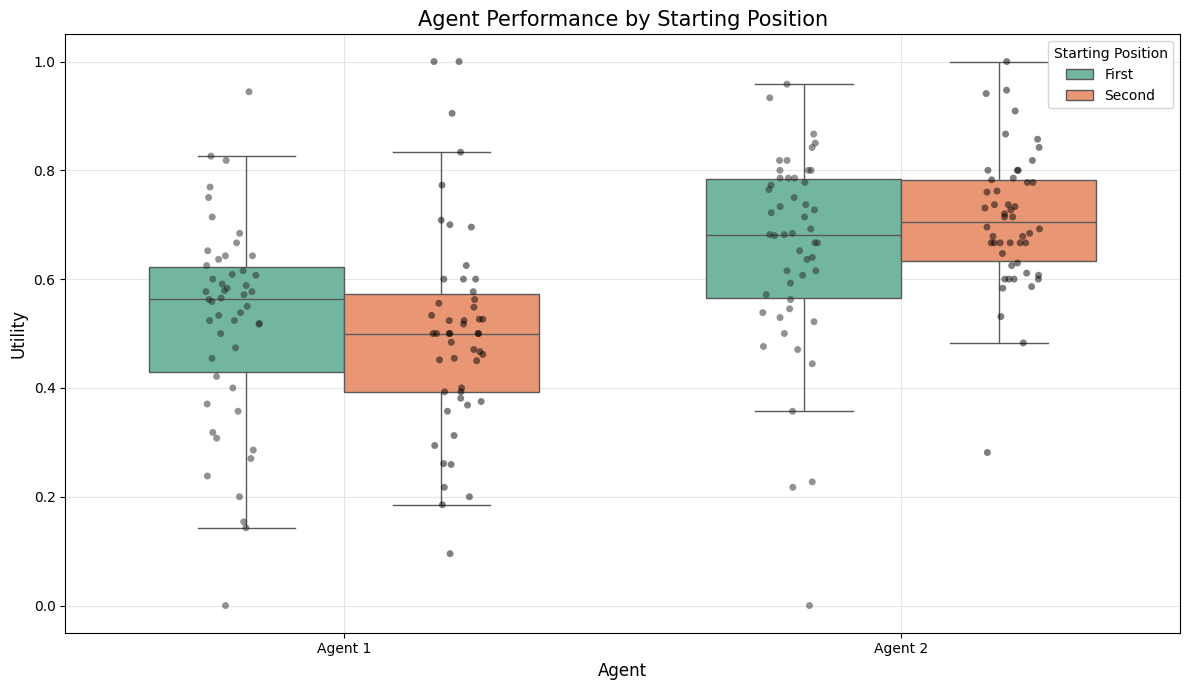

### Starting Position Analysis

#### Summary Statistics by Agent and Position

mean              median                 std           count       
Starting Position     First    Second     First    Second     First    Second First Second
Agent                                                                                     
Agent 1            0.523109  0.503292  0.563859  0.500000  0.186885  0.190159    50     50
Agent 2            0.652353  0.709104  0.681818  0.704969  0.183298  0.124621    50     50

#### First vs. Second Position Comparison

- Mean utility when starting first: 0.588

- Mean utility when starting second: 0.606

- Absolute difference: 0.018

- Percentage difference: 3.1% advantage for second position

#### Statistical Significance Test

**Independent t-test**:

- t-statistic: -0.677

- p-value: 0.4992 (not statistically significant)

- Effect size (Cohen's d): 0.096 (negligible)

#### Agent-Specific Analysis

**Agent 1**

- Mean when starting first: 0.523

- Mean when starting second: 0.503

- Position advantage: First

- Statistical significance: p=0.6004 (not significant)

**Agent 2**

- Mean when starting first: 0.652

- Mean when starting second: 0.709

- Position advantage: Second

- Statistical significance: p=0.0737 (not significant)

### Summary

The analysis shows a not statistically significant Second-mover advantage in negotiations (default and rude), with a 3.1% utility benefit and negligible effect size (d=0.096). Interestingly, Agent 1 performs better when going first, while Agent 2 performs better when going second, suggesting different strategic advantages based on agent type and position.

In [13]:
# Side-by-Side Box and Whisker Plot: Agent Performance When Starting First vs Second
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from IPython.display import Markdown, display

if 'metrics_df' in globals() and not metrics_df.empty:
    # Check if we have the starting_agent column
    if 'starting_agent' in metrics_df.columns:
        # Create figure
        plt.figure(figsize=(12, 7))
        
        # Create a new DataFrame to hold the plotting data
        plot_data = []
        
        # For rounds where Agent 1 started
        agent1_start = metrics_df[metrics_df['starting_agent'] == 1]
        if not agent1_start.empty:
            # Agent 1's performance when starting first
            for _, row in agent1_start.iterrows():
                plot_data.append({
                    'Agent': 'Agent 1',
                    'Starting Position': 'First',
                    'Utility': row['agent1_utility']
                })
            
            # Agent 2's performance when going second
            for _, row in agent1_start.iterrows():
                plot_data.append({
                    'Agent': 'Agent 2',
                    'Starting Position': 'Second',
                    'Utility': row['agent2_utility']
                })
        
        # For rounds where Agent 2 started
        agent2_start = metrics_df[metrics_df['starting_agent'] == 2]
        if not agent2_start.empty:
            # Agent 2's performance when starting first
            for _, row in agent2_start.iterrows():
                plot_data.append({
                    'Agent': 'Agent 2',
                    'Starting Position': 'First',
                    'Utility': row['agent2_utility']
                })
            
            # Agent 1's performance when going second
            for _, row in agent2_start.iterrows():
                plot_data.append({
                    'Agent': 'Agent 1',
                    'Starting Position': 'Second',
                    'Utility': row['agent1_utility']
                })
        
        # Convert to DataFrame for plotting
        plot_df = pd.DataFrame(plot_data)
        
        if not plot_df.empty:
            # Create the boxplot
            sns.boxplot(
                x='Agent',
                y='Utility',
                hue='Starting Position',
                data=plot_df,
                palette='Set2',
                showfliers=False,
                width=0.7
            )
            
            # Add individual data points for more detail
            sns.stripplot(
                x='Agent',
                y='Utility',
                hue='Starting Position',
                data=plot_df,
                dodge=True,
                alpha=0.5,
                jitter=True,
                color='black',
                legend=False
            )
            
            plt.title('Agent Performance by Starting Position', fontsize=15)
            plt.xlabel('Agent', fontsize=12)
            plt.ylabel('Utility', fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # Statistical Analysis
            display(Markdown("### Starting Position Analysis"))
            
            # Display pivot table with summary statistics
            pivot = plot_df.pivot_table(
                values='Utility',
                index='Agent',
                columns='Starting Position',
                aggfunc=['mean', 'median', 'std', 'count']
            )
            
            display(Markdown("#### Summary Statistics by Agent and Position"))
            display(pivot)
            
            # Extract data for first vs. second position comparison
            first = plot_df[plot_df['Starting Position'] == 'First']['Utility']
            second = plot_df[plot_df['Starting Position'] == 'Second']['Utility']
            
            # Basic statistics
            first_mean = first.mean()
            second_mean = second.mean()
            diff = first_mean - second_mean
            
            display(Markdown("#### First vs. Second Position Comparison"))
            display(Markdown(f"- Mean utility when starting first: {first_mean:.3f}"))
            display(Markdown(f"- Mean utility when starting second: {second_mean:.3f}"))
            display(Markdown(f"- Absolute difference: {abs(diff):.3f}"))
            display(Markdown(f"- Percentage difference: {abs(diff)/min(first_mean, second_mean)*100:.1f}% advantage for {'first' if diff > 0 else 'second'} position"))
            
            # Perform t-test
            t_stat, p_val = stats.ttest_ind(first, second, equal_var=False)
            
            display(Markdown("#### Statistical Significance Test"))
            display(Markdown(f"**Independent t-test**:"))
            display(Markdown(f"- t-statistic: {t_stat:.3f}"))
            display(Markdown(f"- p-value: {p_val:.4f} ({'statistically significant' if p_val < 0.05 else 'not statistically significant'})"))
            
            # Calculate effect size (Cohen's d)
            # Pooled standard deviation
            n1, n2 = len(first), len(second)
            s1, s2 = first.std(), second.std()
            pooled_std = np.sqrt(((n1-1)*(s1**2) + (n2-1)*(s2**2)) / (n1+n2-2))
            cohen_d = abs(first_mean - second_mean) / pooled_std
            
            # Interpret effect size
            if cohen_d < 0.2:
                effect = "negligible"
            elif cohen_d < 0.5:
                effect = "small"
            elif cohen_d < 0.8:
                effect = "medium"
            else:
                effect = "large"
                
            display(Markdown(f"- Effect size (Cohen's d): {cohen_d:.3f} ({effect})"))
            
            # Agent-specific analysis
            display(Markdown("#### Agent-Specific Analysis"))
            
            # For Agent 1
            agent1_first = plot_df[(plot_df['Agent'] == 'Agent 1') & (plot_df['Starting Position'] == 'First')]['Utility']
            agent1_second = plot_df[(plot_df['Agent'] == 'Agent 1') & (plot_df['Starting Position'] == 'Second')]['Utility']
            
            if len(agent1_first) > 1 and len(agent1_second) > 1:
                t_stat, p_val = stats.ttest_ind(agent1_first, agent1_second, equal_var=False)
                display(Markdown(f"**Agent 1**"))
                display(Markdown(f"- Mean when starting first: {agent1_first.mean():.3f}"))
                display(Markdown(f"- Mean when starting second: {agent1_second.mean():.3f}"))
                display(Markdown(f"- Position advantage: {'First' if agent1_first.mean() > agent1_second.mean() else 'Second'}"))
                display(Markdown(f"- Statistical significance: p={p_val:.4f} ({'significant' if p_val < 0.05 else 'not significant'})"))
            
            # For Agent 2
            agent2_first = plot_df[(plot_df['Agent'] == 'Agent 2') & (plot_df['Starting Position'] == 'First')]['Utility']
            agent2_second = plot_df[(plot_df['Agent'] == 'Agent 2') & (plot_df['Starting Position'] == 'Second')]['Utility']
            
            if len(agent2_first) > 1 and len(agent2_second) > 1:
                t_stat, p_val = stats.ttest_ind(agent2_first, agent2_second, equal_var=False)
                display(Markdown(f"**Agent 2**"))
                display(Markdown(f"- Mean when starting first: {agent2_first.mean():.3f}"))
                display(Markdown(f"- Mean when starting second: {agent2_second.mean():.3f}"))
                display(Markdown(f"- Position advantage: {'First' if agent2_first.mean() > agent2_second.mean() else 'Second'}"))
                display(Markdown(f"- Statistical significance: p={p_val:.4f} ({'significant' if p_val < 0.05 else 'not significant'})"))
            
            # Summary
            display(Markdown("### Summary"))
            
            advantage = "First" if first_mean > second_mean else "Second"
            significance = "statistically significant" if p_val < 0.05 else "not statistically significant"
            
            # Get agent types if available
            if 'agent1_type' in metrics_df.columns and 'agent2_type' in metrics_df.columns:
                agent1_type = metrics_df['agent1_type'].iloc[0]
                agent2_type = metrics_df['agent2_type'].iloc[0]
                agent_info = f"({agent1_type} and {agent2_type})"
            else:
                agent_info = ""
            
            summary_text = (
                f"The analysis shows a {significance} {advantage}-mover advantage in negotiations {agent_info}, " +
                f"with a {abs(diff)/min(first_mean, second_mean)*100:.1f}% utility benefit and {effect} effect size (d={cohen_d:.3f}). "
            )
            
            # Add agent-specific insights
            if len(agent1_first) > 1 and len(agent1_second) > 1 and len(agent2_first) > 1 and len(agent2_second) > 1:
                agent1_adv = "first" if agent1_first.mean() > agent1_second.mean() else "second"
                agent2_adv = "first" if agent2_first.mean() > agent2_second.mean() else "second"
                
                if agent1_adv == agent2_adv:
                    summary_text += f"Both agents perform better when going {agent1_adv} in the negotiation."
                else:
                    summary_text += (
                        f"Interestingly, Agent 1 performs better when going {agent1_adv}, while " +
                        f"Agent 2 performs better when going {agent2_adv}, suggesting different " +
                        f"strategic advantages based on agent type and position."
                    )
                    
            display(Markdown(summary_text))
        else:
            print("No data available to plot after filtering.")
    else:
        print("Error: 'starting_agent' column not found in the data.")
else:
    print("metrics_df not available yet. Run the loading cells above.")